In [1]:
import os
import librosa
import librosa.display
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from IPython.display import Audio
from google.colab import drive

warnings.filterwarnings('ignore')

In [2]:
# Mounting the Google Drive to import the TESS dataset to Colab

drive.mount('/content/drive')

!cp /content/drive/MyDrive/TESS.zip .
!unzip -q TESS.zip

Mounted at /content/drive


In [3]:
# This block of code assembles the dataset to a single directory

old_data_path = '/content/TESS Toronto emotional speech set data/'
new_data_path = '/content/datafiles/'
data_dirs = os.listdir(old_data_path)
all_files = 0
moved = 0

if not os.path.isdir(new_data_path):
  os.mkdir(new_data_path)

for dir in data_dirs:
  files = os.listdir(old_data_path + dir)
  all_files += len(files)

  for file in files:
    os.rename(old_data_path + dir + '/' + file, new_data_path + file)
    moved += 1
    
print('There are a total of ' + str(len(os.listdir(new_data_path))) + ' audio files in the dataset.')

There are a total of 2800 audio files in the dataset.


In [4]:
!rm -rf TESS* tess* sample_data # Removes redundant files and directories

In [5]:
# Creating a manual data loader

paths = []
labels = []

for audio_file in os.listdir(new_data_path):
  file_name = audio_file.split('_')
  _, word, label = file_name[0], file_name[1], file_name[2].split('.')[0]

  paths.append(new_data_path + audio_file)
  labels.append(label.lower())

print('Dataset loaded.')

Dataset loaded.


In [6]:
# Creating a dataframe

df = pd.DataFrame()

df['speech'] = paths
df['labels'] = labels
df.head()

,speech,labels
0,/content/datafiles/OAF_red_sad.wav,sad
1,/content/datafiles/YAF_tire_ps.wav,ps
2,/content/datafiles/OAF_ditch_angry.wav,angry
3,/content/datafiles/YAF_lid_angry.wav,angry
4,/content/datafiles/OAF_talk_disgust.wav,disgust


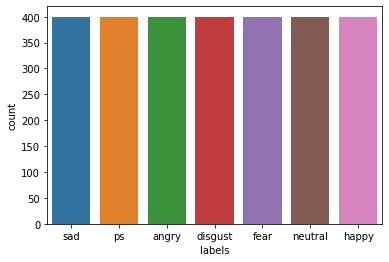

In [7]:
# Visualizing how many labels we have

sns.countplot(df['labels'])

In [8]:
# This function displays the waveplot of an audio file
def waveplot(data, sample_rate, emotion):
  plt.figure(figsize=(10,4))
  plt.title(emotion, size=20)
  librosa.display.waveplot(data, sr=sample_rate)
  plt.show()

# This function displays the spectogram of an audio file
def spectogram(data, sample_rate, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(x)

  plt.figure(figsize=(10,4))
  plt.title(emotion, size=20)
  librosa.display.specshow(xdb, sr=sample_rate, x_axis='time', y_axis='hz')
  plt.colorbar()

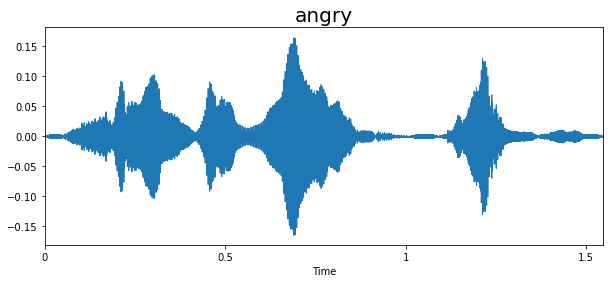

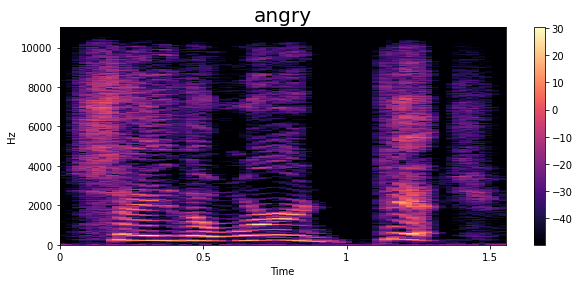

In [9]:
# Overviewing a sample audio file

emotion = 'angry'

path = df['speech'][df['labels']==emotion].iloc[0]
data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [10]:
# This function extracts the mel frequency cepstral coefficients features of a sample audio file

def extract_mfcc(filename):
  y, sr = librosa.load(filename, duration=3, offset=0.5)
  mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
  return mfcc

In [11]:
extract_mfcc(df['speech'].iloc[0]) # Viewing the mfcc features of a sample audio file

array([-5.72234436e+02,  1.26958824e+02,  3.56497078e+01,  1.42976236e+01,
        2.15431576e+01,  1.74161034e+01, -1.62674599e+01, -1.83449459e+01,
       -1.80686550e+01,  2.42379165e+00, -1.64107952e+01,  5.14796352e+00,
       -2.52404594e+00,  1.57689941e+00, -1.66849232e+00, -1.35173607e+00,
       -4.80750275e+00,  6.25417566e+00, -4.66947645e-01, -2.19806242e+00,
        2.99544382e+00, -3.95431471e+00, -3.60058522e+00, -1.32008755e+00,
       -1.18982439e+01,  3.30144835e+00, -4.61045027e+00, -2.68840647e+00,
       -5.26708603e+00, -4.09343988e-01, -4.12819815e+00,  5.65881729e+00,
        3.91242218e+00,  5.55156946e+00,  8.11404610e+00,  8.25154781e+00,
        1.39278488e+01,  1.88682308e+01,  2.06308632e+01,  2.47645149e+01],
      dtype=float32)

In [12]:
# Loading the features of all audio files (this takes a bit long)

X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
X_mfcc = np.array([i for i in X_mfcc]) 
X_mfcc

array([[-5.72234436e+02,  1.26958824e+02,  3.56497078e+01, ...,
         1.88682308e+01,  2.06308632e+01,  2.47645149e+01],
       [-3.40145294e+02,  7.95912018e+01, -2.88362217e+01, ...,
         4.41313457e+00,  2.50793791e+00,  5.54950857e+00],
       [-4.95013489e+02,  5.56353531e+01,  2.52555060e+00, ...,
         9.98989105e+00,  7.05345154e-01,  1.97915268e+00],
       ...,
       [-2.90080719e+02,  8.13703995e+01, -2.43967146e-01, ...,
         1.76838923e+00, -4.58013043e-02,  6.88211024e-01],
       [-4.54633942e+02,  1.05505859e+02, -1.43143141e+00, ...,
         7.85998285e-01,  7.56216943e-01,  2.65602040e+00],
       [-4.86259888e+02,  7.71614151e+01,  2.13121243e+01, ...,
         3.52852936e+01,  1.23945026e+01,  1.98139095e+00]], dtype=float32)

In [13]:
# This is the input slit. Converting the inputs to a format accepted by the LSTM model.

X = np.expand_dims(X_mfcc, -1)
X.shape

(2800, 40, 1)

In [14]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['labels']]) # One Hot Encoding the labels
y = y.toarray()

In [15]:
# Create the LSTM model

model = Sequential([
    LSTM(128, return_sequences = False, input_shape = (40,1)),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(7, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 77,127
Trainable params: 77,127
Non-traina

In [16]:
# Training

history = model.fit(X, y, validation_split = 0.2, epochs=100, batch_size = 256, shuffle = True)

Epoch 1/100
9/9 [==============================] - 8s 85ms/step - loss: 1.8657 - accuracy: 0.2795 - val_loss: 1.7081 - val_accuracy: 0.4464
Epoch 2/100
9/9 [==============================] - 0s 10ms/step - loss: 1.6070 - accuracy: 0.4656 - val_loss: 1.3466 - val_accuracy: 0.5446
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 1.2590 - accuracy: 0.5612 - val_loss: 0.9438 - val_accuracy: 0.6607
Epoch 4/100
9/9 [==============================] - 0s 10ms/step - loss: 0.9718 - accuracy: 0.6335 - val_loss: 0.7185 - val_accuracy: 0.7339
Epoch 5/100
9/9 [==============================] - 0s 10ms/step - loss: 0.7681 - accuracy: 0.7000 - val_loss: 0.5098 - val_accuracy: 0.8375
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 0.6025 - accuracy: 0.7821 - val_loss: 0.3518 - val_accuracy: 0.9018
Epoch 7/100
9/9 [==============================] - 0s 10ms/step - loss: 0.4834 - accuracy: 0.8281 - val_loss: 0.2342 - val_accuracy: 0.9268
Epoch 8/100
9/9 [===

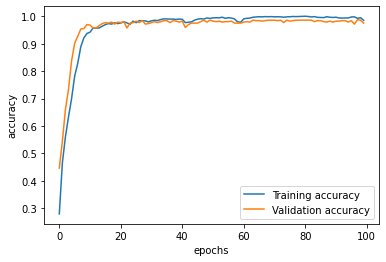

In [17]:
# Plot the results

epochs = list(range(100))
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

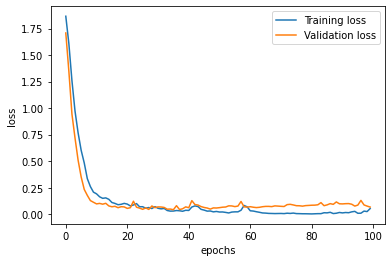

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()